# parallel_bootstrap example

Load example output from parallel_bootstrap.  Five models were fitted to real-estate data obtained using the code in the streeteasy_scrape repository.  The output here was generated using code in bashBoot directory, but identical results can be obtained using code from the sparkBoot directory.  The details of the models are explained in the streeteasy_model repository.  Here, we will plot 95% confidence intervals on the model fit statistics (RMSE and R<sup>2</sup>) to evaluate the statistical significance of differences across models.   

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from parallel_bootstrap import txt2df, predict, rmse_dist, r2_dist

Get the distribution of RMSE and R<sup>2</sup> for each model.

In [2]:
model_list = ['reduced','scraped','amen','trans','inter']
coef = {}; info = {}; feats = {}; target = {}; pred = {}; rmse = {}; r2 = {}
for m in model_list:
    #display
    print "Now analyzing %s..." % (m),
    #format coefficients in dataframe
    coef[m], info[m] = txt2df('example_output/bashBoot_output_%s_train.txt' % (m))
    #load data
    feats_temp = pd.read_csv('bashBoot/data/%s_feats.csv' % (m)).drop('Unnamed: 0',axis=1)
    target_temp = pd.read_csv('bashBoot/data/%s_target.csv' % (m)).drop('Unnamed: 0',axis=1)
    #reduce to only test set
    feats[m]  = feats_temp[feats_temp['test_set'] == 1]
    target[m] = target_temp[feats_temp['test_set'] == 1]
    #drop column
    feats[m] = feats[m].drop('test_set',axis=1)    
    #generate predictions
    pred[m] = predict(coef[m],feats[m])
    #compute rmse distribution over bootstraps
    rmse[m] = rmse_dist(target[m]['price'],pred[m])
    #compute r2 distribution over bootstraps
    r2[m] = r2_dist(target[m]['price'],pred[m])
    #print
    print "Finished."

Now analyzing reduced... Finished.
Now analyzing scraped... Finished.
Now analyzing amen... Finished.
Now analyzing trans... Finished.
Now analyzing inter... Finished.


Compute the standard error and 95% confidence intervals (2-tailed) for RMSE and R<sup>2</sup>.

In [3]:
rmse_stats = {'mean': np.array([]), 'se': np.array([]), 'LB': np.array([]), 'UB': np.array([])}
r2_stats = {'mean': np.array([]), 'se': np.array([]), 'LB': np.array([]), 'UB': np.array([])}
for m in model_list:
    rmse_stats['mean'] =  np.append(rmse_stats['mean'],np.mean(rmse[m]))
    rmse_stats['se'] =  np.append(rmse_stats['se'],np.std(rmse[m]))
    rmse_stats['LB'] =  np.append(rmse_stats['LB'],np.percentile(rmse[m],2.5))
    rmse_stats['UB'] =  np.append(rmse_stats['UB'],np.percentile(rmse[m],97.5))
    r2_stats['mean'] =  np.append(r2_stats['mean'],np.mean(r2[m]))
    r2_stats['se'] =  np.append(r2_stats['se'],np.std(r2[m]))
    r2_stats['LB'] =  np.append(r2_stats['LB'],np.percentile(r2[m],2.5))
    r2_stats['UB'] =  np.append(r2_stats['UB'],np.percentile(r2[m],97.5))
    

### Summarize in tables

RMSE

In [4]:
rmse_df = pd.DataFrame(rmse_stats)
rmse_df.rename(columns = {'LB': '95% CI (lower bound)', 'UB':'95% CI (upper bound)','mean':'Mean','se':'Standard error'}, inplace = True)
rmse_df.rename(index = {0: 'reduced', 1:'scraped',2:'amen',3:'trans',4:'inter'})

,95% CI (lower bound),95% CI (upper bound),Mean,Standard error
reduced,1267.360383,1273.886184,1270.647768,1.794453
scraped,959.515808,964.675980,962.079568,1.316796
amen,876.808132,881.855295,879.441172,1.438867
trans,874.117474,879.719122,876.972675,1.539755
inter,747.381252,855.210794,768.629552,29.178826


R<sup>2</sup>

In [5]:
r2_df = pd.DataFrame(r2_stats)
r2_df.rename(columns = {'LB': '95% CI (lower bound)', 'UB':'95% CI (upper bound)','mean':'Mean','se':'Standard error'}, inplace = True)
r2_df.rename(index = {0: 'reduced', 1:'scraped',2:'amen',3:'trans',4:'inter'})

,95% CI (lower bound),95% CI (upper bound),Mean,Standard error
reduced,0.483199,0.488480,0.485822,0.001452
scraped,0.703636,0.706798,0.705229,0.000807
amen,0.752339,0.755166,0.753693,0.000806
trans,0.753538,0.756666,0.755073,0.000860
inter,0.767013,0.822112,0.811582,0.015657


### Plot with error bars.

Plot RMSE for each model with standard error bars.

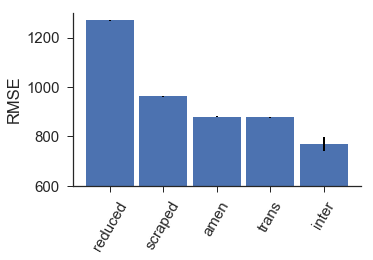

In [6]:
#RMSE bar plot with SE
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,rmse_stats['mean'],yerr = rmse_stats['se'],width = w,
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([600,1300])
ax.set_xticks(ind)
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('RMSE')

Plot RMSE for each model with 95% CI error bars.

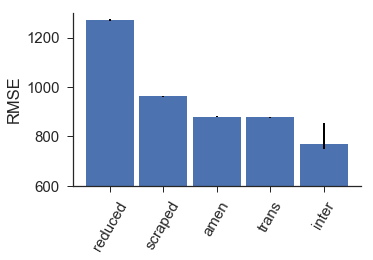

In [7]:
#RMSE bar plot with 95% CIs
sns.set_style("ticks")
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,rmse_stats['mean'],width=w,yerr = [rmse_stats['mean']-rmse_stats['LB'],rmse_stats['UB']-rmse_stats['mean']],
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([600,1300])
ax.set_xticks(ind)
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('RMSE')

Plot R<sup>2</sup> for each model with standard error bars.

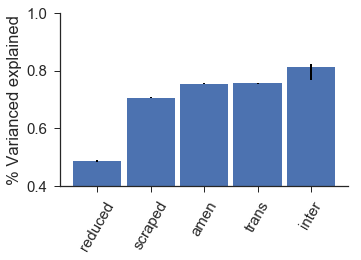

In [8]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,r2_stats['mean'],yerr = [r2_stats['mean']-r2_stats['LB'],r2_stats['UB']-r2_stats['mean']],width=w,
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([0.4,1])
ax.set_xticks(ind)
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('% Varianced explained')

Plot R<sup>2</sup> for each model with 95% CI error bars.

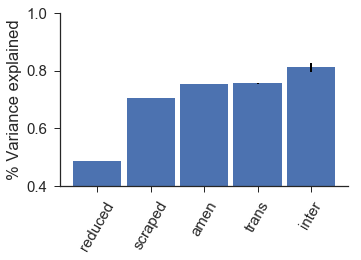

In [9]:
#RMSE bar plot with SE
sns.set_style("ticks")
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([.2,.2,.4,.4])
sns.despine()
ind = np.arange(1,len(model_list)+1,1)
w = 0.9
ax.bar(ind,r2_stats['mean'],yerr = r2_stats['se'],width = w,
       error_kw=dict(ecolor='k',lw=2))
ax.set_ylim([.4,1])
ax.set_xticks(ind)
ax.set_xticklabels(model_list,rotation=60)
ax.set_ylabel('% Variance explained')

### Feature importance/stability

With adequate regulariztion, lasso regression returns a sparse weight vector.  We can use the proportion of times that a particular feature received a non-zero weight as a measure of feature importance/stability.  An important caveat here is that features may be collinear, so we cannot conclude that a feature is not informative just because it is not frequently selected, but a feature that is consistently selected must have some information about the target variable.

In [10]:
#compute proportion nonzero coefficients for each feature and sort
coef_inter = pd.DataFrame(coef['inter'])
p_nonzero = coef_inter.applymap(lambda x:int(x != 0)).apply(sum, axis = 0)/np.shape(coef_inter)[0]
p_nonzero = p_nonzero.sort_values()

Out of the 2984 features in the model, 1126 are selected >50% of the time.  Features that are rarely or never selected could be dropped to improve efficiency.

In [11]:
#how many selected features at least 50% of time
print "Total features in model: %d" % (len(p_nonzero))
print "Total features selected >50%%: %d" % (sum(p_nonzero > 0.5))


Total features in model: 2984
Total features selected >50%: 1126


Checking different subsets of features reveals that the basic features (i.e., beds, baths, square feet, days listed, rooms, and unit type) are nearly always selected.   

In [12]:
#check feature importance for basic variables
basic_feats = ['beds','baths','sq_ft','days_on_streeteasy','rooms']
print 'Proportion selected:'
print p_nonzero[basic_feats]
#check feature importance of unit type
unit_type_list = [i for i in coef_inter.columns if "unit_type" in i]
print ' '
print p_nonzero[unit_type_list]

Proportion selected:
beds                  1.0
baths                 1.0
sq_ft                 1.0
days_on_streeteasy    1.0
rooms                 1.0
dtype: float64
 
unit_type_Apartment       0.980198
unit_type_Building        1.000000
unit_type_Co-op           0.910891
unit_type_Condo           0.900990
unit_type_Condop          0.900990
unit_type_House           0.475248
unit_type_Multi-family    0.643564
unit_type_Other type      0.198020
unit_type_Rental Unit     0.990099
unit_type_Townhouse       0.990099
dtype: float64


All amenities are nearly always selected, indicating their importance in predicting rental price.

In [13]:
#check feature importance of amenities
#nearly every amenity is consistently selected
amen_list = ['bike_room', 'board_approval_required', 'cats_and_dogs_allowed',
             'central_air_conditioning', 'concierge', 'cold_storage', 'community_recreation_facilities',
             'children_playroom', 'deck', 'dishwasher', 'doorman', 'elevator', 'full_time_doorman',
             'furnished', 'garage_parking', 'green_building', 'gym', 'garden', 'guarantors_accepted',
             'laundry_in_building', 'live_in_super', 'loft', 'package_room', 'parking_available',
             'patio', 'pets_allowed', 'roof_deck', 'smoke_free', 'storage_available', 'sublet',
             'terrace', 'virtual_doorman', 'washer_dryer_in_unit', 'waterview', 'waterfront']
print p_nonzero[amen_list]

bike_room                          0.970297
board_approval_required            1.000000
cats_and_dogs_allowed              0.960396
central_air_conditioning           1.000000
concierge                          1.000000
cold_storage                       0.990099
community_recreation_facilities    0.980198
children_playroom                  1.000000
deck                               0.960396
dishwasher                         1.000000
doorman                            1.000000
elevator                           1.000000
full_time_doorman                  0.970297
furnished                          1.000000
garage_parking                     1.000000
green_building                     1.000000
gym                                1.000000
garden                             1.000000
guarantors_accepted                1.000000
laundry_in_building                0.950495
live_in_super                      1.000000
loft                               1.000000
package_room                    

Neighborhoods are variable. Some are reliably selected and others are never selected. Neighborhoods that consistently have cofficients of zero may have average prices near the intercept of the model (in which case they are unnecessary) or across-neighborhood differences may be explained through the interaction terms.

In [14]:
#check feature importance of neighborhoods
#note that some zero coefficients, may that variance soaked up by interaction terms
neighborhood_list = [i for i in coef_inter.columns if "neighborhood" in i]
print '======='
print p_nonzero[neighborhood_list]

neighborhood_Alley Park              0.000000
neighborhood_Annadale                0.000000
neighborhood_Arrochar                0.000000
neighborhood_Arverne                 0.000000
neighborhood_Astoria                 1.000000
neighborhood_Auburndale              0.000000
neighborhood_Bath Beach              0.118812
neighborhood_Battery Park City       1.000000
neighborhood_Bay Ridge               0.950495
neighborhood_Bay Terrace (Queens)    0.009901
neighborhood_Baychester              0.000000
neighborhood_Bayside                 0.019802
neighborhood_Bayswater               0.000000
neighborhood_Bedford Park            0.782178
neighborhood_Bedford-Stuyvesant      1.000000
neighborhood_Beechhurst              0.000000
neighborhood_Beekman                 0.920792
neighborhood_Belle Harbor            0.000000
neighborhood_Bellerose               0.000000
neighborhood_Belmont                 0.000000
neighborhood_Bensonhurst             0.000000
neighborhood_Bergen Beach         